<a href="https://colab.research.google.com/github/catalyst2064/Fiber/blob/main/Fiber(Matrix).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実装編

In [1]:
#--------------------------------------------------
# 必須ライブラリ
#--------------------------------------------------

import numpy as np

#--------------------------------------------------
# データを可視化
#--------------------------------------------------

import matplotlib.pyplot as plt
import pandas as pd

#--------------------------------------------------
# データセットの取得とデータの前処理
#--------------------------------------------------

from sklearn.datasets import load_wine
from sklearn.datasets import load_iris

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#--------------------------------------------------
# Kerasの動作を比較
#--------------------------------------------------

from tensorflow import keras
from keras.layers import Dense

#--------------------------------------------------
# ユーティリティ
#--------------------------------------------------

class Object: pass                                # 最小限のオブジェクトを生成

def judge(flag):                                  # 論理値を判定文字列に変換
    return '✓ PASS' if flag else '✗ FAIL'

#--------------------------------------------------
# 動作環境の設定
#--------------------------------------------------

%config InlineBackend.figure_format = 'retina'    # 図の描画を高精細に
np.set_printoptions(formatter={'float':'{: .8f}'.format}) # 数値の表示を整える


## Fiberを構成する関数群

In [2]:
#--------------------------------------------------
# _fini_ ← 初期化関数（initialization function）
#--------------------------------------------------

def glorot_uniform(rows, cols):                   # glorot uniform（デフォルト）
    min = -np.sqrt(6 / (rows + cols))
    max =  np.sqrt(6 / (rows + cols))
    return np.random.uniform(min, max, (rows, cols))

def he_normal(rows, cols):                        # he normal (for ReLU)
    std = np.sqrt(2 / cols)
    return np.random.normal(0.0, std, (rows, cols))

def xavier_normal(rows, cols):                    # xavier normal (for sigmoid, tanh)
    std = 1 / np.sqrt(cols)
    return np.random.normal(0.0, std, (rows, cols))

#--------------------------------------------------
# _fact_ ← 活性化関数（activation function）
#--------------------------------------------------

def sigmoid(x):                                   # sigmoid関数
    return 1 / (1 + np.exp(-x))

def tanh(x):                                      # tanh関数
    return np.tanh(x)

def relu(x):                                      # ReLU関数
    return np.maximum(0, x)

def softmax(x):                                   # softmax関数（行列対応版）
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

#--------------------------------------------------
# _fder_ ← 導関数（derivative function）
#--------------------------------------------------

def sigmoid_der(x):                               # sigmoid関数の導関数
    return sigmoid(x) * (1.0 - sigmoid(x))

def tanh_der(x):                                  # tanh関数の導関数
    return 1.0 - (tanh(x) ** 2)

def relu_der(x):                                  # ReLU関数の導関数
    return np.where(x > 0, 1, 0)

#--------------------------------------------------
# _flos_ ← 損失関数（loss function）
#--------------------------------------------------

def bin_xentropy(y, t):                           # 交差エントロピー関数（二値）
    delta = 1e-7
    return -np.sum(t * np.log(y + delta) + (1 - t) * np.log(1 - y + delta))

def mul_xentropy(y, t):                           # 交差エントロピー関数（多値）
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

#--------------------------------------------------
# _feva_ ← 評価関数（evaluation function）
#--------------------------------------------------

def bin_scoring(y, t):                            # 採点関数（二値）
    return np.sum(np.round(y) == np.round(t))

def mul_scoring(y, t):                            # 採点関数（多値）
    return np.sum(np.argmax(y, axis=1) == np.argmax(t, axis=1))


### 動作確認

In [3]:
#--------------------------------------------------
# テストデータ
#--------------------------------------------------
x_vector = np.array(
    [0.3, 0.5, 0.9, 0.7, 0.1]
)
x_matrix = np.array([
    [0.3, 0.5, 0.9, 0.7, 0.1],
    [0.9, 0.7, 0.1, 0.3, 0.5],
    [0.1, 0.3, 0.5, 0.9, 0.7]
])

#--------------------------------------------------
# 活性化関数にベクトルと行列を与えて結果が同じになること
#--------------------------------------------------
funcs = [
    ('sigmoid', sigmoid(x_vector),      sigmoid(x_matrix)[0]),
    ('tanh',    tanh(x_vector),         tanh(x_matrix)[0]),
    ('relu',    relu(x_vector),         relu(x_matrix)[0])
]

for func in funcs:
    diff = np.all(func[1] - func[2] == 0)
    print(f'{func[0]:11s}: {judge(diff)}')

#--------------------------------------------------
# 導関数にベクトルと行列を与えて結果が同じになること
#--------------------------------------------------
funcs = [
    ('sigmoid_der', sigmoid_der(x_vector), sigmoid_der(x_matrix)[0]),
    ('tanh_der',    tanh_der(x_vector),    tanh_der(x_matrix)[0]),
    ('relu_der',    relu_der(x_vector),    relu_der(x_matrix)[0])
]

print()
for func in funcs:
    diff = np.all(func[1] - func[2] == 0)
    print(f'{func[0]:11s}: {judge(diff)}')


sigmoid    : ✓ PASS
tanh       : ✓ PASS
relu       : ✓ PASS

sigmoid_der: ✓ PASS
tanh_der   : ✓ PASS
relu_der   : ✓ PASS


## Fiber（行列版）

In [4]:
#--------------------------------------------------
# レイヤ（パラメータを管理）
#--------------------------------------------------
class Layer:
    def __init__(self, rows, cols, funcs):
        (self._fact_, self._fder_, self._fini_) = funcs
        core = self._fini_(rows+1, cols)
        self.W = core[0:rows]                     # 重み
        self.b = core[-1]                         # バイアス

    def output(self, X):                          # 出力値を計算
        self.X = X
        self.U = X @ self.W + self.b              # 式 (1.1)
        return self._fact_(self.U)                # 式 (1.2)

    def calc_delta(self, X_grad):                 # 誤差を計算
        return X_grad * self._fder_(self.U)       # 式 (1.4)

    def calc_grad(self, delta):                   # 勾配を計算
        self.W_grad = self.X.T @ delta            # 式 (1.6)
        self.b_grad = np.sum(delta, axis=0)       # 式 (1.7)
        return delta @ self.W.T                   # 式 (1.5)

    def update(self, eta):                        # パラメータを更新
        self.W -= eta * self.W_grad               # 式 (1.8)
        self.b -= eta * self.b_grad               # 式 (1.9)

#--------------------------------------------------
# コーテクス（レイヤを管理）
#--------------------------------------------------
class Cortex:
    def __init__(self, cols, eta):
        self.layers = []                          # レイヤの一覧
        self.rows = cols                          # 最初のレイヤの行数を確定
        self.eta = eta                            # 学習率

    def add(self, cols, funcs):                   # レイヤを追加
        layer = Layer(self.rows, cols, funcs)
        self.layers.append(layer)
        self.rows = cols                          # 次のレイヤの行数を確定

    def measurer(self, funcs):                    # 測定系の関数を設定
        (self._flos_, self._feva_) = funcs

    def forward(self, X):                         # 順伝播
        for layer in self.layers:
            X = layer.output(X)
        return X

    def backward(self, delta):                    # 逆伝播
        layers = list(reversed(self.layers))
        X_grad = layers[0].calc_grad(delta)
        for layer in layers[1:]:
            delta  = layer.calc_delta(X_grad)
            X_grad = layer.calc_grad(delta)

    def batch(self, X, T):                        # バッチ
        Y = self.forward(X)
        delta = Y - T                             # 式 (1.3)
        self.backward(delta)
        loss = self._flos_(Y, T)
        accu = self._feva_(Y, T)
        return (loss, accu)

    def update(self):                             # パラメータを更新
        for layer in self.layers:
            layer.update(self.eta)

#--------------------------------------------------
# モデル
#--------------------------------------------------
class Model:
    def __init__(self, cols, eta):
        self.cortex = Cortex(cols, eta)

    @staticmethod
    def idx_mini(total_size, batch_size):         # ミニバッチ用のインデックスを作成
        whole = np.random.permutation(total_size)
        idx_slice = range(0, total_size, batch_size)
        return [whole[i:i+batch_size] for i in idx_slice]

    def add(self, cols, fact, fder=lambda x:None, fini=glorot_uniform): # レイヤを追加
        funcs = (fact, fder, fini)
        self.cortex.add(cols, funcs)

    def measurer(self, flos, feva):               # 測定系の関数を設定
        funcs = (flos, feva)
        self.cortex.measurer(funcs)

    def fit(self, X_train, T_train, ds_valid=None, epochs=1, batch_size=1): # 最適化
        train_size = len(X_train)
        memo = Object()
        memo.train = Object()                     # 測定結果（訓練データ）
        memo.train.loss = []
        memo.train.accu = []
        if ds_valid is not None:
            X_valid = ds_valid[0]
            T_valid = ds_valid[1]
            valid_size = len(X_valid)
            memo.valid = Object()                 # 測定結果（検証データ）
            memo.valid.loss = []
            memo.valid.accu = []
        for epo in range(epochs):
            if ds_valid is not None:
                (loss, accu) = self.cortex.batch(X_valid, T_valid)
                memo.valid.loss.append(loss / valid_size)
                memo.valid.accu.append(accu / valid_size)
            Loss, Accu = 0, 0
            whole = self.idx_mini(train_size, batch_size)
            for mini in whole:
                (loss, accu) = self.cortex.batch(X_train[mini], T_train[mini])
                self.cortex.update()
                Loss += loss
                Accu += accu
            memo.train.loss.append(Loss / train_size)
            memo.train.accu.append(Accu / train_size)
        return memo

    def predict(self, X):                         # 予測
        return self.cortex.forward(X)


# 動作確認編

## 動作確認をサポートするユーティリティ

In [5]:
#--------------------------------------------------
# Fiberのパラメータをダイレクトに操作
#--------------------------------------------------
class DirectFiber:
    @staticmethod
    def coreinit(model, cores):                   # パラメータを初期化
        for (i, (W, b)) in enumerate(cores):
            layer = model.cortex.layers[i]
            (layer.W, layer.b) = (W.copy(), b.copy())

    @staticmethod
    def coredump(model):                          # 重みの現在値を出力
        whole = []
        for layer in model.cortex.layers:
            whole.append(layer.W)
        return whole

#--------------------------------------------------
# Kerasのパラメータをダイレクトに操作
#--------------------------------------------------
class DirectKeras:
    @staticmethod
    def coreinit(model, cores):                   # パラメータを初期化
        for (i, (W, b)) in enumerate(cores):
            model.layers[i].set_weights([W.copy(), b.copy()])

    @staticmethod
    def coredump(model):                          # 重みの現在値を出力
        whole = []
        for layer in model.layers:
            whole.append(layer.get_weights()[0])
        return whole

#--------------------------------------------------
# ３レイヤ分のパラメータを作成
#--------------------------------------------------
def make_3cores():
    def make_1core(rows, cols):
        core = glorot_uniform(rows+1, cols)       # バイアス用に１行多く作成
        return (core[0:rows], core[-1])           # 重み，バイアス

    core1 = make_1core(5, 4)
    core2 = make_1core(4, 3)
    core3 = make_1core(3, 2)
    return [core1, core2, core3]

#--------------------------------------------------
# 重みを表示
#--------------------------------------------------
def show_coredump(core):
    for (i, core) in enumerate(core):
        print(np.array(core))

#--------------------------------------------------
# 重みの差分が許容範囲内であれば「PASS」
#--------------------------------------------------
def show_corediff(w1, w2, limit):
    memo = []
    for (w1, w2) in zip(w1, w2):                  # レイヤごとに重みの差を表示
        w1 = np.array(w1)
        w2 = np.array(w2)
        diff = np.abs(w1 - w2)
        memo.append(np.all(diff < limit))         # 許容範囲内ならTrueを追加
        print(diff)
    print(f'許容できる差分の限界： {limit}')
    for (i, memo) in enumerate(memo):             # レイヤごとに判定結果を表示
        print(f'Layer {i+1}: {judge(memo)}')


## 動作確認

In [6]:
#--------------------------------------------------
# パラメータを更新（Fiber）
#--------------------------------------------------
def test_Fiber(cores, X_train, T_train, epochs, eta):
    direct = DirectFiber
    model = Model(5, eta)
    model.add(4, sigmoid, sigmoid_der)
    model.add(3, sigmoid, sigmoid_der)
    model.add(2, softmax)
    model.measurer(mul_xentropy, mul_scoring)
    direct.coreinit(model, cores)
    model.fit(X_train, T_train, epochs=epochs, batch_size=1)
    return direct.coredump(model)

#--------------------------------------------------
# パラメータを更新（Keras）
#--------------------------------------------------
def test_Keras(cores, X_train, T_train, epochs, eta):
    direct = DirectKeras
    model = keras.Sequential()
    model.add(Dense(4, 'sigmoid', input_shape=(5,))),
    model.add(Dense(3, 'sigmoid')),
    model.add(Dense(2, 'softmax'))
    direct.coreinit(model, cores)
    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=eta),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model.fit(X_train, T_train, epochs=epochs, batch_size=1, verbose=0)
    return direct.coredump(model)

#--------------------------------------------------
# 動作確認（パラメータの更新結果を比較する）
#--------------------------------------------------
cores = make_3cores()                             # 重み、バイアス
x_train = np.array([ [0.1, 0.3, 0.5, 0.7, 0.9] ]) # 特徴量データ
t_train = np.array([ [1, 0] ])                    # 正解値データ

limit = 1e-7                                      # 許容できる差分の限界
eta = 0.01                                        # 学習率
epochs = 5                                        # エポック

W_fbr = test_Fiber(cores, x_train, t_train, epochs, eta)
W_krs = test_Keras(cores, x_train, t_train, epochs, eta)

print('Fiberが算出した重み')
show_coredump(W_fbr)

print('\nKerasが算出した重み')
show_coredump(W_krs)

print('\n重みの差分（Fiber vs. Keras）')
show_corediff(W_fbr, W_krs, limit)


Fiberが算出した重み
[[-0.09048060 -0.66969257  0.21774935  0.23963468]
 [-0.41494093  0.75499732 -0.00401721  0.44798731]
 [ 0.00697081  0.61749977 -0.27337889 -0.40904420]
 [ 0.71996196  0.01295608 -0.38629792  0.16687279]
 [-0.26155022 -0.27338615  0.53744987  0.63746937]]
[[-0.37302207  0.13698628  0.62280306]
 [ 0.64786993  0.77724223  0.44768929]
 [ 0.41940134 -0.23606474 -0.61655376]
 [ 0.78084058 -0.51885651 -0.22297065]]
[[ 0.20898560  0.53494076]
 [ 0.00645239 -0.32844580]
 [-0.04171449  0.69357079]]

Kerasが算出した重み
[[-0.09048060 -0.66969252  0.21774937  0.23963468]
 [-0.41494089  0.75499737 -0.00401721  0.44798732]
 [ 0.00697081  0.61749977 -0.27337888 -0.40904418]
 [ 0.71996200  0.01295608 -0.38629791  0.16687280]
 [-0.26155016 -0.27338609  0.53744990  0.63746941]]
[[-0.37302208  0.13698626  0.62280309]
 [ 0.64786988  0.77724218  0.44768929]
 [ 0.41940135 -0.23606473 -0.61655378]
 [ 0.78084058 -0.51885647 -0.22297063]]
[[ 0.20898561  0.53494078]
 [ 0.00645239 -0.32844579]
 [-0.041714

# 演習編

## 演習で使用するデータセットを取得

In [7]:
def drop_rows(ds, colm, cond):                    # 条件に一致する行を削除
    ds.frame  = ds.frame[cond(ds.frame[colm])]
    ds.data   = ds.frame[ds.feature_names]
    ds.target = ds.frame[colm]
    return ds

print('▣  ワインの特徴')
wine = load_wine(as_frame=True)
wine = drop_rows(wine, 'target', lambda colm: colm < 2) # 品種を２種類（0と1）に限定する
display(wine.frame.head())

print('\n▣  アヤメの特徴')
iris = load_iris(as_frame=True)
display(iris.frame.head())


▣  ワインの特徴


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0



▣  アヤメの特徴


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## 演習をサポートするユーティリティ

In [8]:
#--------------------------------------------------
# Kerasの履歴をFiberの履歴に合わせる
#--------------------------------------------------
def adapt_history(src):
    dst = Object()
    dst.train = Object()
    dst.valid = Object()
    dst.train.loss = src.history['loss']
    dst.train.accu = src.history['accuracy']
    dst.valid.loss = src.history['val_loss']
    dst.valid.accu = src.history['val_accuracy']
    return dst

#--------------------------------------------------
# 最適化の進行状況を表示
#--------------------------------------------------
def show_progress(his):
    plt.ylim(0.0, 1.2)
    plt.grid()
    plt.plot(his.train.loss, label='Train loss')
    plt.plot(his.train.accu, label='Train accu')
    plt.plot(his.valid.loss, label='Valid loss')
    plt.plot(his.valid.accu, label='Valid accu')
    plt.xlabel('epochs')
    plt.legend()
    plt.show()
    print('評価指標：')
    print('　　訓練データ：')
    print(f'　　　　損失 = {his.train.loss[-1]:.8f}')
    print(f'　　　　精度 = {his.train.accu[-1]:.8f}')
    print('　　検証データ：')
    print(f'　　　　損失 = {his.valid.loss[-1]:.8f}')
    print(f'　　　　精度 = {his.valid.accu[-1]:.8f}')

#--------------------------------------------------
# データセットを前処理（二値分類）
#--------------------------------------------------
def preproc_bin(ds):
    scaler = StandardScaler()
    X = scaler.fit_transform(ds.data)             # 特徴量を標準化
    T = ds.target.values.reshape(-1,1)
    return train_test_split(X, T, stratify=T)

#--------------------------------------------------
# データセットを前処理（多値分類）
#--------------------------------------------------
def preproc_mul(ds):
    scaler = StandardScaler()
    encoder = OneHotEncoder(sparse_output=False)
    X = scaler.fit_transform(ds.data)             # 特徴量を標準化
    T = ds.target.values.reshape(-1, 1)
    T = encoder.fit_transform(T)                  # 正解値をOne-Hot化
    return train_test_split(X, T, stratify=T)

#--------------------------------------------------
# テスト結果を表示（二値分類）
#--------------------------------------------------
def show_summary_bin(y, t):
    print('\nテスト結果：')
    for (y, t) in zip(y, t):
        ystr = ', '.join([f'{f:.8f}' for f in y])
        pred = np.round(y).astype('int')
        targ = np.round(t)
        rslt = judge(pred == targ)
        print(f'　　予測値 = [{ystr}] ⇨ {pred}, 正解値 = {targ}, {rslt}')

#--------------------------------------------------
# テスト結果を表示（多値分類）
#--------------------------------------------------
def show_summary_mul(y, t):
    print('\nテスト結果：')
    for (y, t) in zip(y, t):
        ystr = ', '.join([f'{f:.8f}' for f in y])
        pred = np.argmax(y)
        targ = np.argmax(t)
        rslt = judge(pred == targ)
        print(f'　　予測値 = [{ystr}] ⇨ {pred}, 正解値 = {targ}, {rslt}')


## 【演習１】二値分類―ワインの特徴から品種を推測する

▣  Fiber


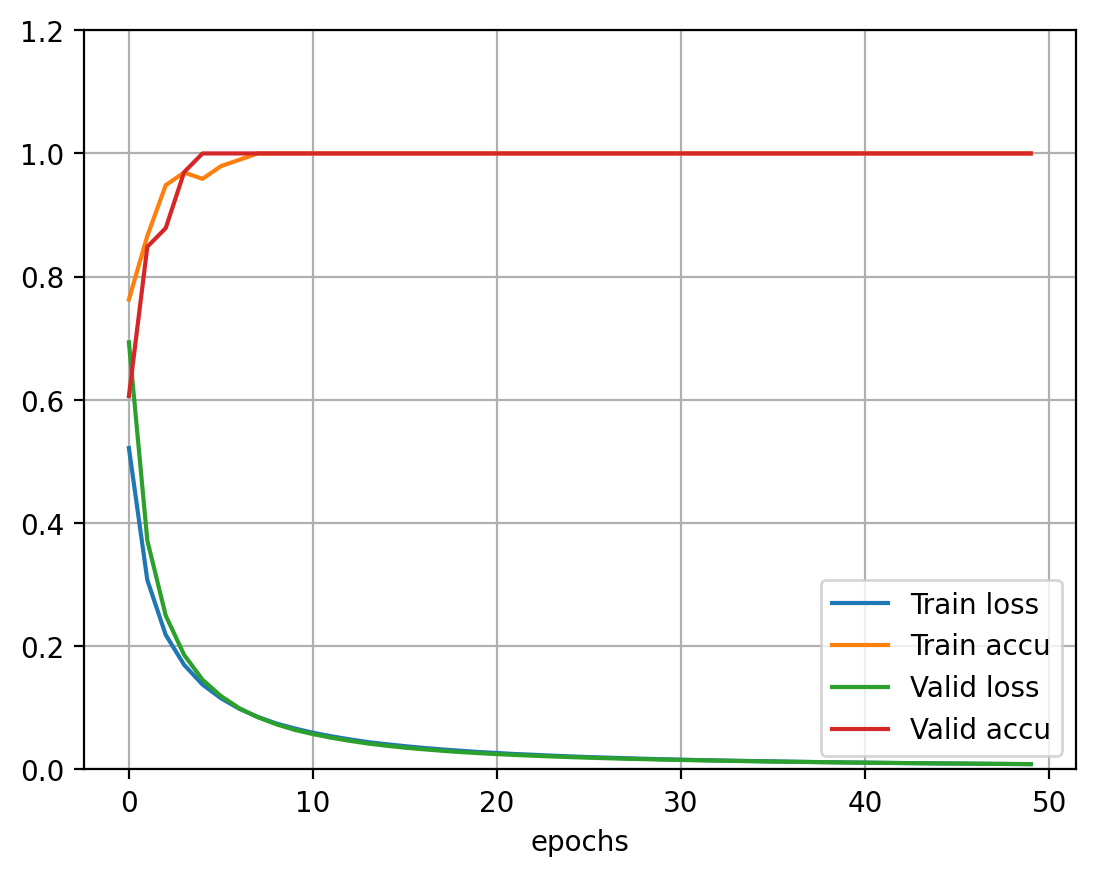

評価指標：
　　訓練データ：
　　　　損失 = 0.00858812
　　　　精度 = 1.00000000
　　検証データ：
　　　　損失 = 0.00869889
　　　　精度 = 1.00000000

テスト結果：
　　予測値 = [0.99892692] ⇨ [1], 正解値 = [1], ✓ PASS
　　予測値 = [0.99665289] ⇨ [1], 正解値 = [1], ✓ PASS
　　予測値 = [0.00124244] ⇨ [0], 正解値 = [0], ✓ PASS
　　予測値 = [0.00096777] ⇨ [0], 正解値 = [0], ✓ PASS
　　予測値 = [0.99782773] ⇨ [1], 正解値 = [1], ✓ PASS
　　予測値 = [0.00119529] ⇨ [0], 正解値 = [0], ✓ PASS
　　予測値 = [0.99881871] ⇨ [1], 正解値 = [1], ✓ PASS
　　予測値 = [0.98947037] ⇨ [1], 正解値 = [1], ✓ PASS
　　予測値 = [0.99833825] ⇨ [1], 正解値 = [1], ✓ PASS
　　予測値 = [0.00412878] ⇨ [0], 正解値 = [0], ✓ PASS

▣  Keras


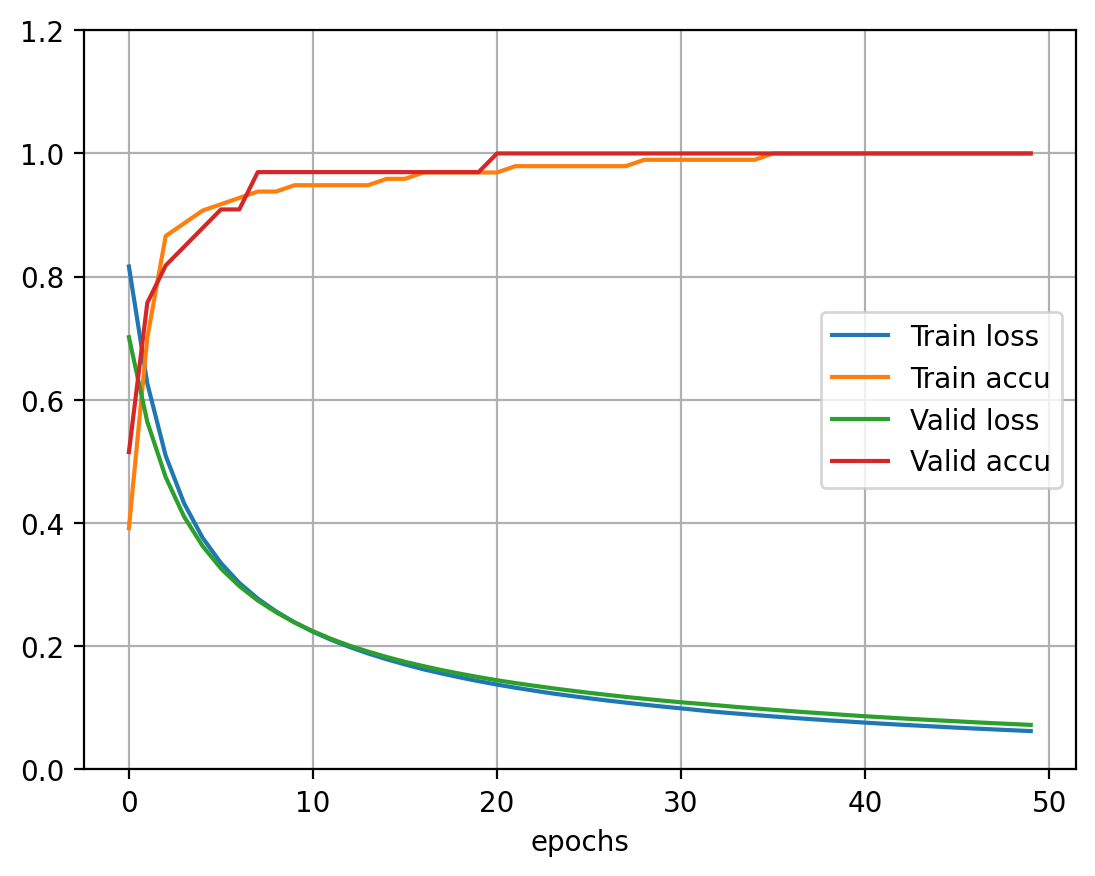

評価指標：
　　訓練データ：
　　　　損失 = 0.06225006
　　　　精度 = 1.00000000
　　検証データ：
　　　　損失 = 0.07235222
　　　　精度 = 1.00000000

テスト結果：
　　予測値 = [0.99311560] ⇨ [1], 正解値 = [1], ✓ PASS
　　予測値 = [0.94609118] ⇨ [1], 正解値 = [1], ✓ PASS
　　予測値 = [0.01723165] ⇨ [0], 正解値 = [0], ✓ PASS
　　予測値 = [0.01292093] ⇨ [0], 正解値 = [0], ✓ PASS
　　予測値 = [0.98327553] ⇨ [1], 正解値 = [1], ✓ PASS
　　予測値 = [0.00975934] ⇨ [0], 正解値 = [0], ✓ PASS
　　予測値 = [0.99459082] ⇨ [1], 正解値 = [1], ✓ PASS
　　予測値 = [0.89838910] ⇨ [1], 正解値 = [1], ✓ PASS
　　予測値 = [0.99471754] ⇨ [1], 正解値 = [1], ✓ PASS
　　予測値 = [0.04111263] ⇨ [0], 正解値 = [0], ✓ PASS


In [9]:
#--------------------------------------------------
# 初期設定（FiberとKerasで共通）
#--------------------------------------------------
(X_train, X_test, T_train, T_test) = preproc_bin(wine)
eta = 0.01                                        # 学習率
epochs = 50
batch_size = 5
limit = 10                                        # 予測で使うテストセットを10件に制限

#--------------------------------------------------
# ワインの品種を推測（Fiber）
#--------------------------------------------------
print('▣  Fiber')
model = Model(13, eta=eta)
model.add(8, tanh, tanh_der)
model.add(1, sigmoid)
model.measurer(bin_xentropy, bin_scoring)
fit = model.fit(X_train, T_train,
                ds_valid=(X_test, T_test),
                epochs=epochs, batch_size=batch_size)
Y_test = model.predict(X_test[:limit])

show_progress(fit)
show_summary_bin(Y_test, T_test[:limit])

#--------------------------------------------------
# ワインの品種を推測（Keras）
#--------------------------------------------------
print('\n▣  Keras')
model = keras.Sequential()
model.add(Dense(8, 'tanh', input_shape=(13,)))
model.add(Dense(1, 'sigmoid'))
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=eta),
    loss='binary_crossentropy',
    metrics=['accuracy'])
fit = model.fit(X_train, T_train,
                validation_data=(X_test, T_test),
                epochs=epochs, batch_size=batch_size, verbose=0)
fit = adapt_history(fit)
Y_test = model.predict(X_test[:limit], verbose=0)

show_progress(fit)
show_summary_bin(Y_test, T_test[:limit])


## 【演習２】多値分類―アヤメの特徴から品種を推測する

▣  Fiber


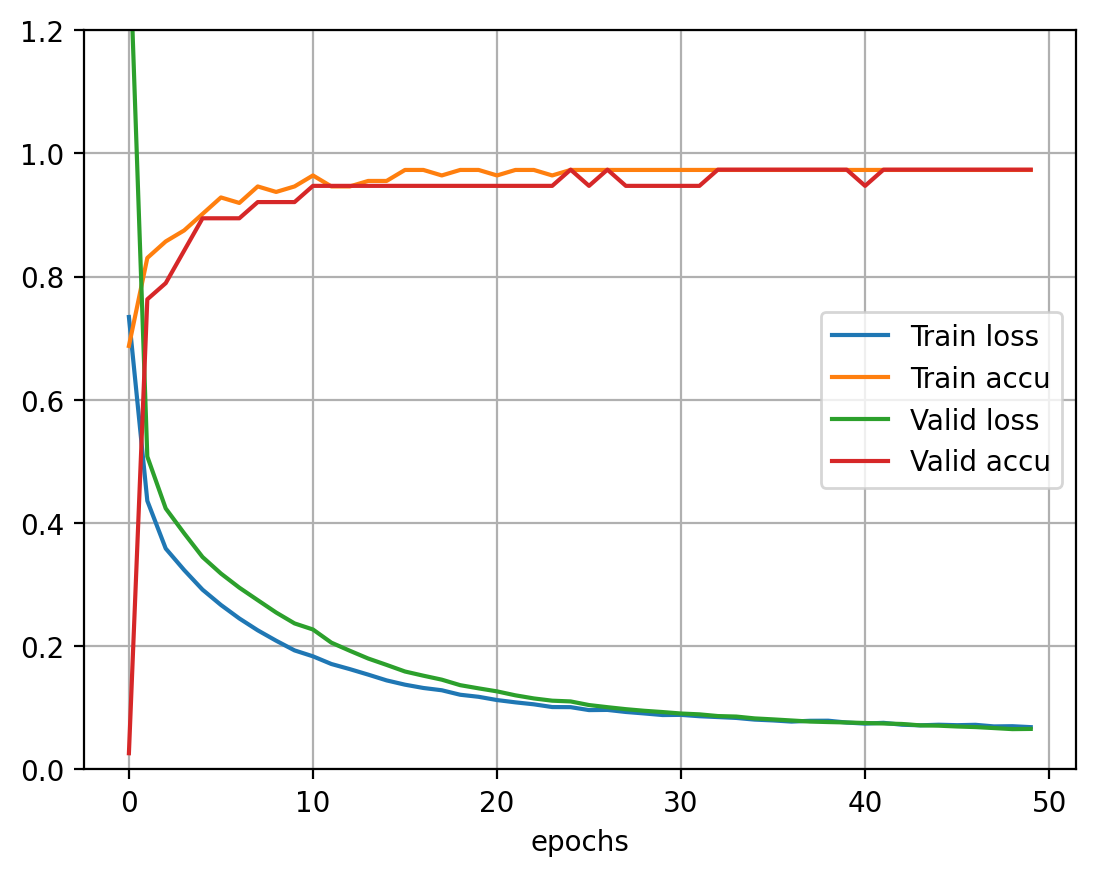

評価指標：
　　訓練データ：
　　　　損失 = 0.06867184
　　　　精度 = 0.97321429
　　検証データ：
　　　　損失 = 0.06576711
　　　　精度 = 0.97368421

テスト結果：
　　予測値 = [0.00106859, 0.91789881, 0.08103261] ⇨ 1, 正解値 = 1, ✓ PASS
　　予測値 = [0.00001006, 0.02905006, 0.97093988] ⇨ 2, 正解値 = 2, ✓ PASS
　　予測値 = [0.02196027, 0.97691790, 0.00112183] ⇨ 1, 正解値 = 1, ✓ PASS
　　予測値 = [0.00000047, 0.00772300, 0.99227654] ⇨ 2, 正解値 = 2, ✓ PASS
　　予測値 = [0.99846456, 0.00153543, 0.00000000] ⇨ 0, 正解値 = 0, ✓ PASS
　　予測値 = [0.00000008, 0.00116467, 0.99883525] ⇨ 2, 正解値 = 2, ✓ PASS
　　予測値 = [0.00157144, 0.92789496, 0.07053360] ⇨ 1, 正解値 = 1, ✓ PASS
　　予測値 = [0.99726801, 0.00273198, 0.00000000] ⇨ 0, 正解値 = 0, ✓ PASS
　　予測値 = [0.00000641, 0.05270940, 0.94728419] ⇨ 2, 正解値 = 2, ✓ PASS
　　予測値 = [0.00860375, 0.97911876, 0.01227748] ⇨ 1, 正解値 = 1, ✓ PASS

▣  Keras


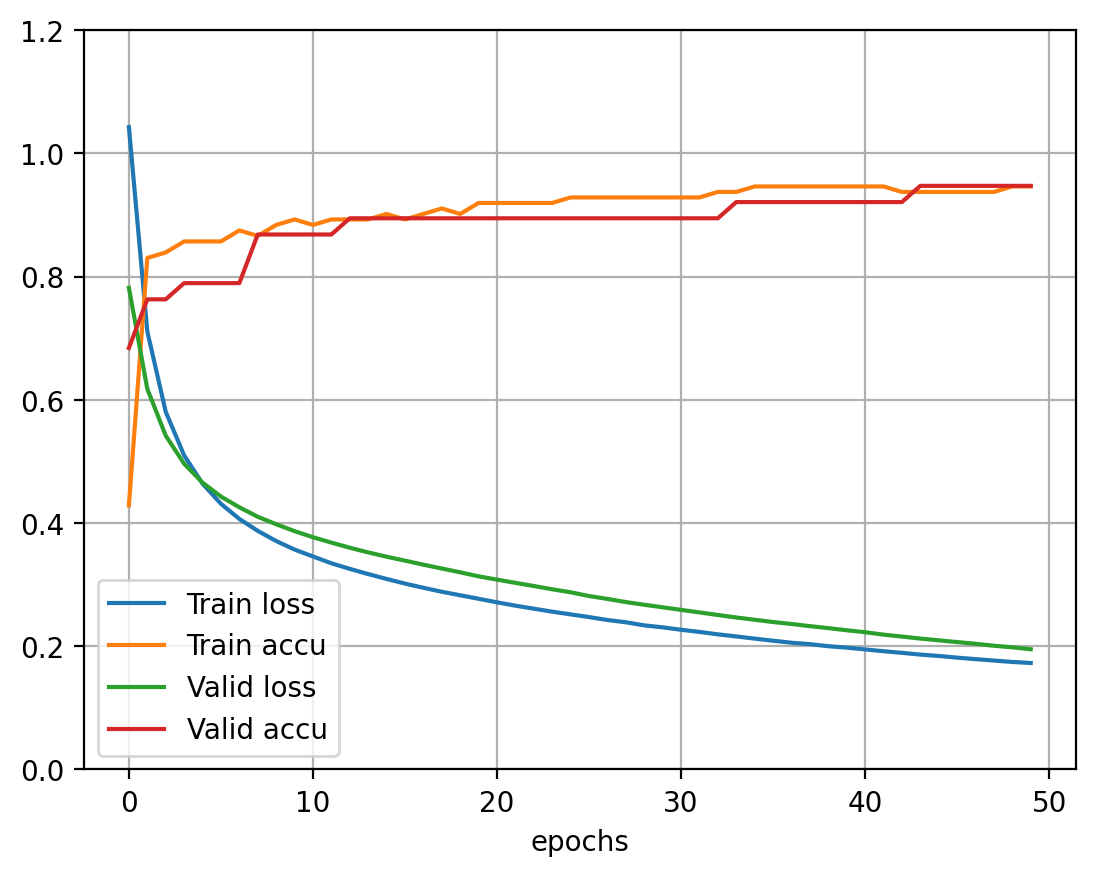

評価指標：
　　訓練データ：
　　　　損失 = 0.17280500
　　　　精度 = 0.94642860
　　検証データ：
　　　　損失 = 0.19507188
　　　　精度 = 0.94736844

テスト結果：
　　予測値 = [0.00697243, 0.58409077, 0.40893683] ⇨ 1, 正解値 = 1, ✓ PASS
　　予測値 = [0.00066998, 0.12607169, 0.87325823] ⇨ 2, 正解値 = 2, ✓ PASS
　　予測値 = [0.09949808, 0.82604694, 0.07445493] ⇨ 1, 正解値 = 1, ✓ PASS
　　予測値 = [0.00016945, 0.11147403, 0.88835651] ⇨ 2, 正解値 = 2, ✓ PASS
　　予測値 = [0.99150115, 0.00846684, 0.00003203] ⇨ 0, 正解値 = 0, ✓ PASS
　　予測値 = [0.00008187, 0.04443382, 0.95548445] ⇨ 2, 正解値 = 2, ✓ PASS
　　予測値 = [0.01163649, 0.71759760, 0.27076581] ⇨ 1, 正解値 = 1, ✓ PASS
　　予測値 = [0.98515600, 0.01480927, 0.00003482] ⇨ 0, 正解値 = 0, ✓ PASS
　　予測値 = [0.00058212, 0.27075526, 0.72866261] ⇨ 2, 正解値 = 2, ✓ PASS
　　予測値 = [0.06164511, 0.81190509, 0.12644982] ⇨ 1, 正解値 = 1, ✓ PASS


In [10]:
#--------------------------------------------------
# 初期設定（FiberとKerasで共通）
#--------------------------------------------------
(X_train, X_test, T_train, T_test) = preproc_mul(iris)
eta = 0.01                                        # 学習率
epochs = 50
batch_size = 5
limit = 10                                        # 予測で使うテストセットを10件に制限

#--------------------------------------------------
# アヤメの品種を推測（Fiber）
#--------------------------------------------------
print('▣  Fiber')
model = Model(4, eta=eta)
model.add(32, tanh, tanh_der)
model.add(3, softmax)
model.measurer(mul_xentropy, mul_scoring)
fit = model.fit(X_train, T_train,
                ds_valid=(X_test, T_test),
                epochs=epochs, batch_size=batch_size)
Y_test = model.predict(X_test[:limit])

show_progress(fit)
show_summary_mul(Y_test, T_test[:limit])

#--------------------------------------------------
# アヤメの品種を推測（Keras）
#--------------------------------------------------
print('\n▣  Keras')
model = keras.Sequential()
model.add(Dense(32, 'tanh', input_shape=(4,)))
model.add(Dense(3, 'softmax'))
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=eta),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
fit = model.fit(X_train, T_train,
                validation_data=(X_test, T_test),
                epochs=epochs, batch_size=batch_size, verbose=0)
fit = adapt_history(fit)
Y_test = model.predict(X_test[:limit], verbose=0)

show_progress(fit)
show_summary_mul(Y_test, T_test[:limit])
